In [1]:
%load_ext autoreload
%autoreload 2

# Validation of Isotropic Gaussian on SO(3)

In [15]:
%pylab inline
import jax.numpy as jnp
import torch
import jax
import jaxlie 
import numpy as np
import lietorch
from gecco_torch.utils.isotropic_gaussian import IsotropicGaussianSO3, _isotropic_gaussian_so3, _isotropic_gaussian_so3_small

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Verify function f

Here we test that the approximation matches well with the series

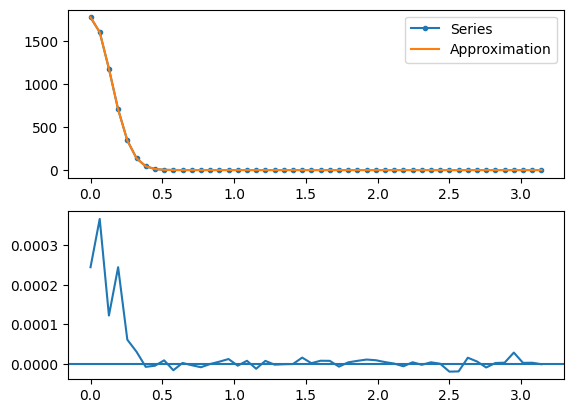

In [3]:
theta = torch.linspace(0,torch.pi,50)
scale = torch.tensor([0.1])
lmax = torch.tensor([100])

subplot(211)
plot(theta, _isotropic_gaussian_so3(theta, scale, lmax), '.-', label='Series')
plot(theta, _isotropic_gaussian_so3_small(theta, scale),  label='Approximation')
legend()

subplot(212)
plot(theta, (_isotropic_gaussian_so3_small(theta, scale) - _isotropic_gaussian_so3(theta, scale, lmax)))
axhline(0)

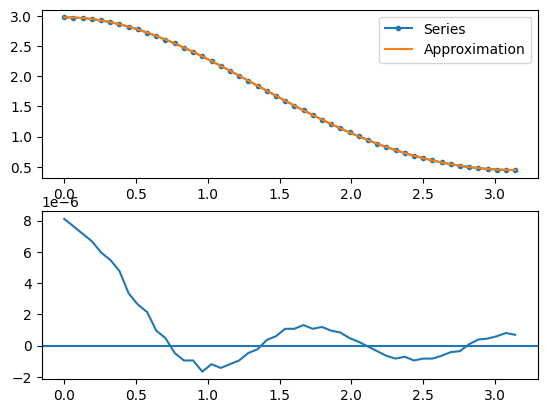

In [4]:
theta = torch.linspace(0,torch.pi,50)
scale = torch.tensor([0.9])
lmax = torch.tensor([3])


subplot(211)
plot(theta, _isotropic_gaussian_so3(theta, scale, lmax), '.-', label='Series')
plot(theta, _isotropic_gaussian_so3_small(theta, scale),  label='Approximation')
legend()

subplot(212)
plot(theta, (_isotropic_gaussian_so3_small(theta, scale) - _isotropic_gaussian_so3(theta, scale, lmax)))
axhline(0)

## Verify that we recover something similar to a Gaussian for very small dispersion

According to https://arxiv.org/abs/2206.08321, we should see something similar to a gaussian

In [5]:
# import tensorflow_probability as tfp; tfp = tfp.substrates.jax
# tfd = tfp.distributions

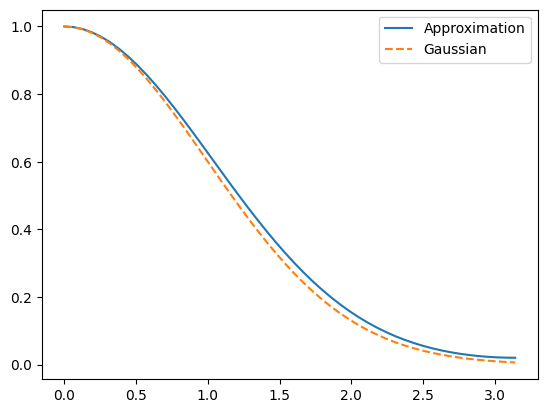

In [6]:
scale = torch.tensor([0.7])
scale_gaussian = torch.sqrt(torch.tensor([2]))*scale
theta = torch.linspace(0, torch.pi,50)
normal_dist = torch.distributions.Normal(0, scale_gaussian)
gaussian_probs = normal_dist.log_prob(theta).exp()
gaussian_probs_normalized = gaussian_probs / gaussian_probs.max()

plot(theta, _isotropic_gaussian_so3_small(theta, scale)/_isotropic_gaussian_so3_small(theta, scale).max(),  label='Approximation')
plot(theta, gaussian_probs_normalized.numpy(), '--', label='Gaussian')
legend()

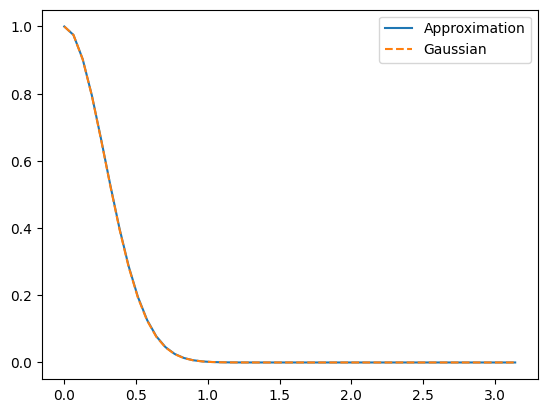

In [7]:
scale = torch.tensor([0.2])
scale_gaussian = torch.sqrt(torch.tensor([2]))*scale
theta = torch.linspace(0, torch.pi,50)
normal_dist = torch.distributions.Normal(0, scale_gaussian)
gaussian_probs = normal_dist.log_prob(theta).exp()
gaussian_probs_normalized = gaussian_probs / gaussian_probs.max()

plot(theta, _isotropic_gaussian_so3_small(theta, scale)/_isotropic_gaussian_so3_small(theta, scale).max(),  label='Approximation')
plot(theta, gaussian_probs_normalized.numpy(), '--', label='Gaussian')
legend()

## Checking the sampling

In [8]:
# import haiku as hk
# rng_seq = hk.PRNGSequence(42)
num_samples = 1024
loc = torch.zeros(4)
loc[3] = 1
scales = torch.tensor(0.1)
dist = IsotropicGaussianSO3(loc,scales)
samples = dist.sample(num_samples)
# samples = dist.sample(seed=jax.random.PRNGKey(0))

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [9]:
# Let's look at the distribution of axis angles
angles = lietorch.SO3(samples).log().norm(dim=-1).cpu().numpy()

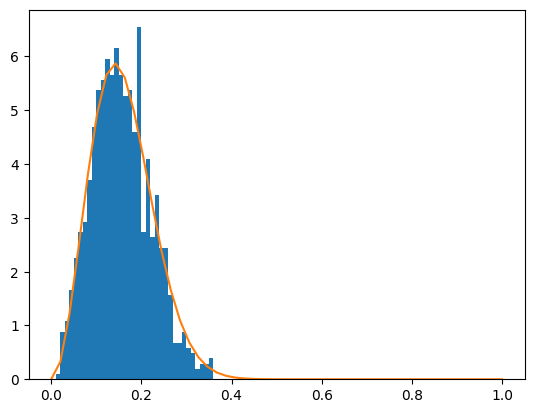

In [10]:
theta = torch.linspace(0, 1, 50)
hist(angles,100, density=True, range=[0,1]);
plot(theta, (1 - torch.cos(theta))/torch.pi * _isotropic_gaussian_so3_small(theta, 0.1/torch.sqrt(torch.tensor([2]))))

## Sample with jax seed

In [11]:
import haiku as hk
rng_seq = hk.PRNGSequence(42)
num_samples = 1024
loc = torch.zeros((num_samples,4))
loc[:,3] = 1
scales = torch.ones((num_samples))*0.1
dist = IsotropicGaussianSO3(loc,scales)
samples = dist.sample_jaxseed(seed=jax.random.PRNGKey(0))

# Let's look at the distribution of axis angles
angles = lietorch.SO3(samples).log().norm(dim=-1).cpu().numpy()

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


RuntimeError: Boolean value of Tensor with more than one value is ambiguous

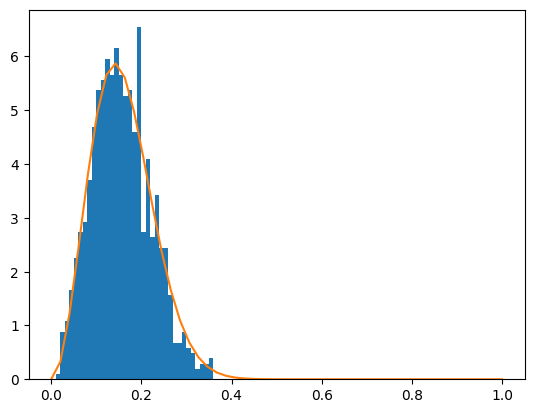

In [12]:
theta = torch.linspace(0, 1, 50)
hist(angles,100, density=True, range=[0,1]);
plot(theta, (1 - torch.cos(theta))/torch.pi * _isotropic_gaussian_so3_small(theta, 0.1/torch.sqrt(torch.tensor([2]))))

## Visualisation of the sampled distribution

In [16]:
from gecco_torch.utils.isotropic_plotting import visualize_so3_probabilities

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


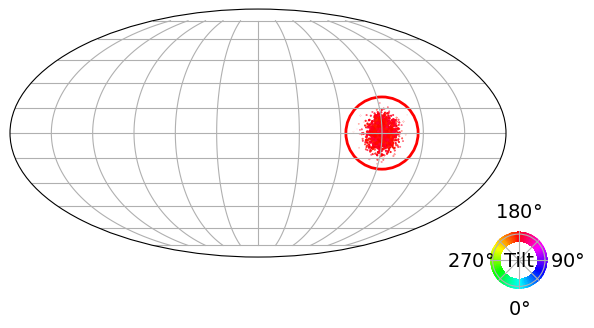

In [17]:


center_jax = jaxlie.SO3.from_x_radians(jnp.pi)

center = torch.from_numpy(np.array(center_jax.wxyz))[[1,2,3,0]]
dist = IsotropicGaussianSO3(center, torch.tensor(0.1))
samples = dist.sample(1000)
prob = torch.exp(dist.log_prob(samples))
prob = jnp.array(prob.cpu().numpy())

data = jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in samples])
visualize_so3_probabilities(
    data,
    0.001*prob/prob.max(),
    rotations_gt=center_jax.as_matrix());

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


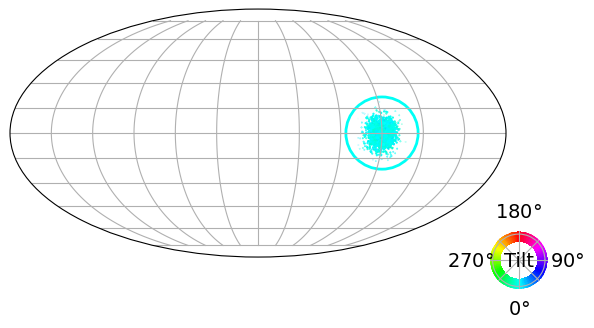

In [18]:
center_jax = jaxlie.SO3.from_x_radians(0)

center = torch.from_numpy(np.array(center_jax.wxyz))[[1,2,3,0]]
dist = IsotropicGaussianSO3(center, torch.tensor(0.1))
samples = dist.sample(1000)
prob = torch.exp(dist.log_prob(samples))
prob = jnp.array(prob.cpu().numpy())

data = jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in samples])
visualize_so3_probabilities(
    data,
    0.001*prob/prob.max(),
    rotations_gt=center_jax.as_matrix());

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


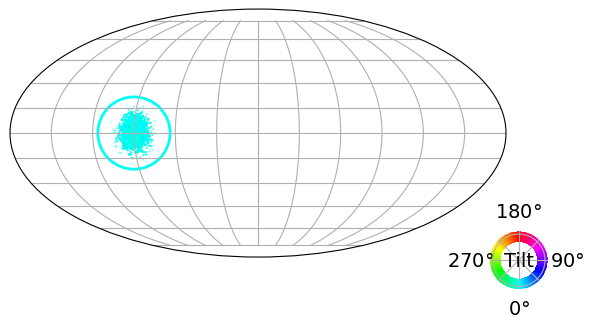

In [19]:
center_jax = jaxlie.SO3.from_z_radians(jnp.pi)

center = torch.from_numpy(np.array(center_jax.wxyz))[[1,2,3,0]]
dist = IsotropicGaussianSO3(center, torch.tensor(0.1))
samples = dist.sample(1000)
prob = torch.exp(dist.log_prob(samples))
prob = jnp.array(prob.cpu().numpy())

data = jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in samples])
visualize_so3_probabilities(
    data,
    0.001*prob/prob.max(),
    rotations_gt=center_jax.as_matrix());

/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(
/home/giese/Documents/gecco/gecco-torch/src/gecco_torch/utils/isotropic_plotting.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([r'90$\degree$', None,


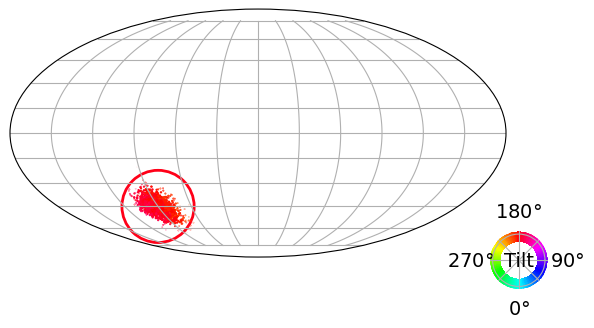

In [20]:
center_jax = jaxlie.SO3.from_y_radians(3*jnp.pi/4)

center = torch.from_numpy(np.array(center_jax.wxyz))[[1,2,3,0]]
dist = IsotropicGaussianSO3(center, torch.tensor(0.1))
samples = dist.sample(1000)
prob = torch.exp(dist.log_prob(samples))
prob = jnp.array(prob.cpu().numpy())

data = jnp.array([jaxlie.SO3(y[[3,0,1,2]].cpu().numpy()).as_matrix() for y in samples])
visualize_so3_probabilities(
    data,
    0.001*prob/prob.max(),
    rotations_gt=center_jax.as_matrix());

## Checking the normalization of the distribution

In [21]:
center_jax = jaxlie.SO3.from_y_radians(3*jnp.pi/4)

center = torch.from_numpy(np.array(center_jax.wxyz))[[1,2,3,0]]
print(center.shape)
dist = IsotropicGaussianSO3(center, torch.tensor(0.1))

torch.Size([4])


/home/giese/miniconda3/envs/gecco/lib/python3.10/site-packages/torch/distributions/distribution.py:53: UserWarning: <class 'gecco_torch.utils.isotropic_gaussian.IsotropicGaussianSO3'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


In [25]:
center_jax = jaxlie.SO3.from_y_radians(3*jnp.pi/4)
n = 1000000
center = torch.from_numpy(np.array(center_jax.wxyz))[[1,2,3,0]]
dist = IsotropicGaussianSO3(center, torch.tensor(0.1))

x = jnp.array(dist.log_prob(lietorch.SO3([],from_uniform_sampled = n).vec().cuda()).cpu().numpy())

hi


In [26]:
x2 = jnp.exp(x - x.max())*jnp.exp(x.max())

In [27]:
x2.sum()/n

Array(0.9065982, dtype=float32)